In [91]:
import requests
import pandas as pd
import datetime
import os
import json
from dotenv import load_dotenv

In [93]:
#Lectura e importacion de datos
id_ind = {'3108001001' : 'Porcentaje analfabetismo',
          '1005000038' : 'Promedio escolaridad',
          '6200205239' : 'Poblacion con educacion basica',
          '6200205241' : 'Poblacion con bachillerato',
          '6200205242' : 'Poblacion con estudios superiores',
          '6207019020' : 'Porcentaje sin escolaridad',
          '1004000001' : 'Derechohabientes'
          }

id_estado = {
    "Aguascalientes": "01",
    "Baja California": "02",
    "Baja California Sur": "03",
    "Campeche": "04",
    "Coahuila de Zaragoza": "05",
    "Colima": "06",
    "Chiapas": "07",
    "Chihuahua": "08",
    "Ciudad de México": "09",
    "Durango": "10",
    "Guanajuato": "11",
    "Guerrero": "12",
    "Hidalgo": "13",
    "Jalisco": "14",
    "México": "15",
    "Michoacán de Ocampo": "16",
    "Morelos": "17",
    "Nayarit": "18",
    "Nuevo León": "19",
    "Oaxaca": "20",
    "Puebla": "21",
    "Querétaro": "22",
    "Quintana Roo": "23",
    "San Luis Potosí": "24",
    "Sinaloa": "25",
    "Sonora": "26",
    "Tabasco": "27",
    "Tamaulipas": "28",
    "Tlaxcala": "29",
    "Veracruz": "30",
    "Yucatán": "31",
    "Zacatecas": "32"
}

load_dotenv()
token_inegi = os.getenv("token_inegi")

indicadores = (",".join(list(id_ind.keys()))).strip()
valores = []

for estado in id_estado:
    inegi_url = f"https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/{indicadores}/es/{id_estado[estado]}/false/BISE/2.0/{token_inegi}?type=json"
    response = requests.get(inegi_url)
    data = response.json()
    for indicador in data['Series']: 
        for observacion in indicador['OBSERVATIONS']:
            indicador_actual = indicador['INDICADOR']
            fecha = observacion['TIME_PERIOD']
            valor = observacion['OBS_VALUE']
            valores.append({"id_estado": id_estado[estado], "estado": estado, "indicador": indicador_actual, "indicador_nombre": id_ind[indicador_actual], "año" : fecha, "valor" : valor})

        

In [99]:
#Creacion del dataframe
df_edu = pd.DataFrame(valores)

In [101]:
#Guardado de dataframe

def descarga_csv(dataframe, nombre_carpeta, nombre_archivo):
    """
    Guarda el DataFrame en un archivo CSV en la carpeta destino.

    Args:
        dataframe (pd.DataFrame): El DataFrame a guardar.
        nombre_carpeta (str): La ruta de la carpeta donde se guarda el archivo.
        nombre_archivo (str): El nombre del archivo CSV.
    """
    try:
        if not os.path.exists(nombre_carpeta):
            os.makedirs(nombre_carpeta)
            print(f"Se creó la carpeta: '{nombre_carpeta}'")

        ruta_completa = os.path.join(nombre_carpeta, nombre_archivo)
        dataframe.to_csv(ruta_completa, index=False, encoding='utf-8')
        
        print(f"Archivo con dataframe de educacion y salud creado en: '{ruta_completa}'")

    except Exception as e:
        print(f"Ocurrió un error al guardar el archivo: {e}")


carpeta_destino = '../data/raw/'
archivo_destino = 'educacionysalud.csv'

descarga_csv(df_edu, carpeta_destino, archivo_destino)

Archivo con dataframe de educacion y salud creado en: '../data/raw/educacionysalud.csv'


In [103]:
#Creacion de archivo de información de descarga
ruta_ref = r"..\references"

def generar_registro_datos(fuentes, directorio_salida = ruta_ref):
    """
    Genera un archivo de texto con la descripción de las fuentes de datos,
    adaptado para manejar tanto archivos estáticos como consultas a APIs.

    Args:
        fuentes (list): Una lista de diccionarios con la info de cada fuente.
        directorio_salida (str): El nombre de la carpeta donde se guardará el archivo.
    """
    os.makedirs(directorio_salida, exist_ok=True)
    ruta_completa = os.path.join(directorio_salida, "registro_fuentes.txt")
    fecha_acceso = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    try:
        with open(ruta_completa, "w", encoding="utf-8") as f:
            f.write("="*50 + "\n")
            f.write("REGISTRO DE FUENTES DE DATOS\n")
            f.write("="*50 + "\n\n")

            for i, fuente in enumerate(fuentes, 1):
                f.write("-"*50 + "\n")
                f.write(f"--- Fuente de Datos #{i} ---\n")
                f.write(f"Nombre: {fuente.get('nombre', 'No especificado')}\n")
                
                # Revisa si es una API o un archivo y escribe los campos correspondientes
                if fuente.get('tipo') == 'API':
                    f.write(f"Tipo: API\n")
                    f.write(f"Fecha de Query: {fecha_acceso}\n")
                    f.write(f"Endpoint: {fuente.get('endpoint', 'No especificado')}\n")
                    
                    # Formatea los parámetros para que sean legibles
                    params = fuente.get('parametros', {})
                    if params:
                        f.write("Parámetros de Query:\n")
                        f.write(json.dumps(params, indent=4))
                        f.write("\n")
                        
                    f.write(f"URL Documentación: {fuente.get('url_documentacion', 'No especificada')}\n")
                else: # Asume que es un archivo por defecto
                    f.write(f"Tipo: Archivo Estático\n")
                    f.write(f"Fecha de Descarga: {fecha_acceso}\n")
                    f.write(f"URL de Descarga: {fuente.get('url_descarga', 'No especificada')}\n")
                    f.write(f"Enlace para más información: {fuente.get('url_info', 'No especificado')}\n")
                
                f.write(f"Descripción: {fuente.get('descripcion', 'No especificada')}\n\n")

        print(f"Se ha generado el archivo en la ruta '{ruta_completa}' correctamente.")

    except IOError as e:
        print(f"Error al escribir en el archivo: {e}")

mis_fuentes = []

for codigo, nombre in id_ind.items():
    fuente = {
        "nombre": f"Indicador: {nombre} (Todos los estados)",
        "tipo": "API",
        # El endpoint se muestra como una plantilla para indicar que se iteró sobre el estado
        "endpoint": f"https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/{codigo}/es/{{id_estado}}/false/BISE/2.0/token_inegi",
        "parametros": {
            "indicador": codigo,
            # Se especifica el rango geográfico de la consulta
            "area_geografica": "Claves '01' a '32' (Todos los estados de la Republica Mexicana)",
            "reciente": "false",
            "fuente_datos": "BISE",
            "version_api": "2.0"
        },
        "url_documentacion": "https://www.inegi.org.mx/servicios/api_indicadores.html",
        "descripcion": f"Consulta a la API de INEGI para obtener la serie de datos sobre '{nombre}' para cada uno de los 32 estados de México."
    }
    mis_fuentes.append(fuente)

generar_registro_datos(mis_fuentes)

Se ha generado el archivo en la ruta '..\references\registro_fuentes.txt' correctamente.


In [15]:
#Revisamos si hay valores nulos
df_edu_wide.isna().sum()

id_estado        0
estado           0
fecha            0
derhab         351
pob_bac        383
pob_edbas      415
pob_edsup      383
porc_analf      32
porc_sined     415
promedio_ed    319
dtype: int64

<Axes: >

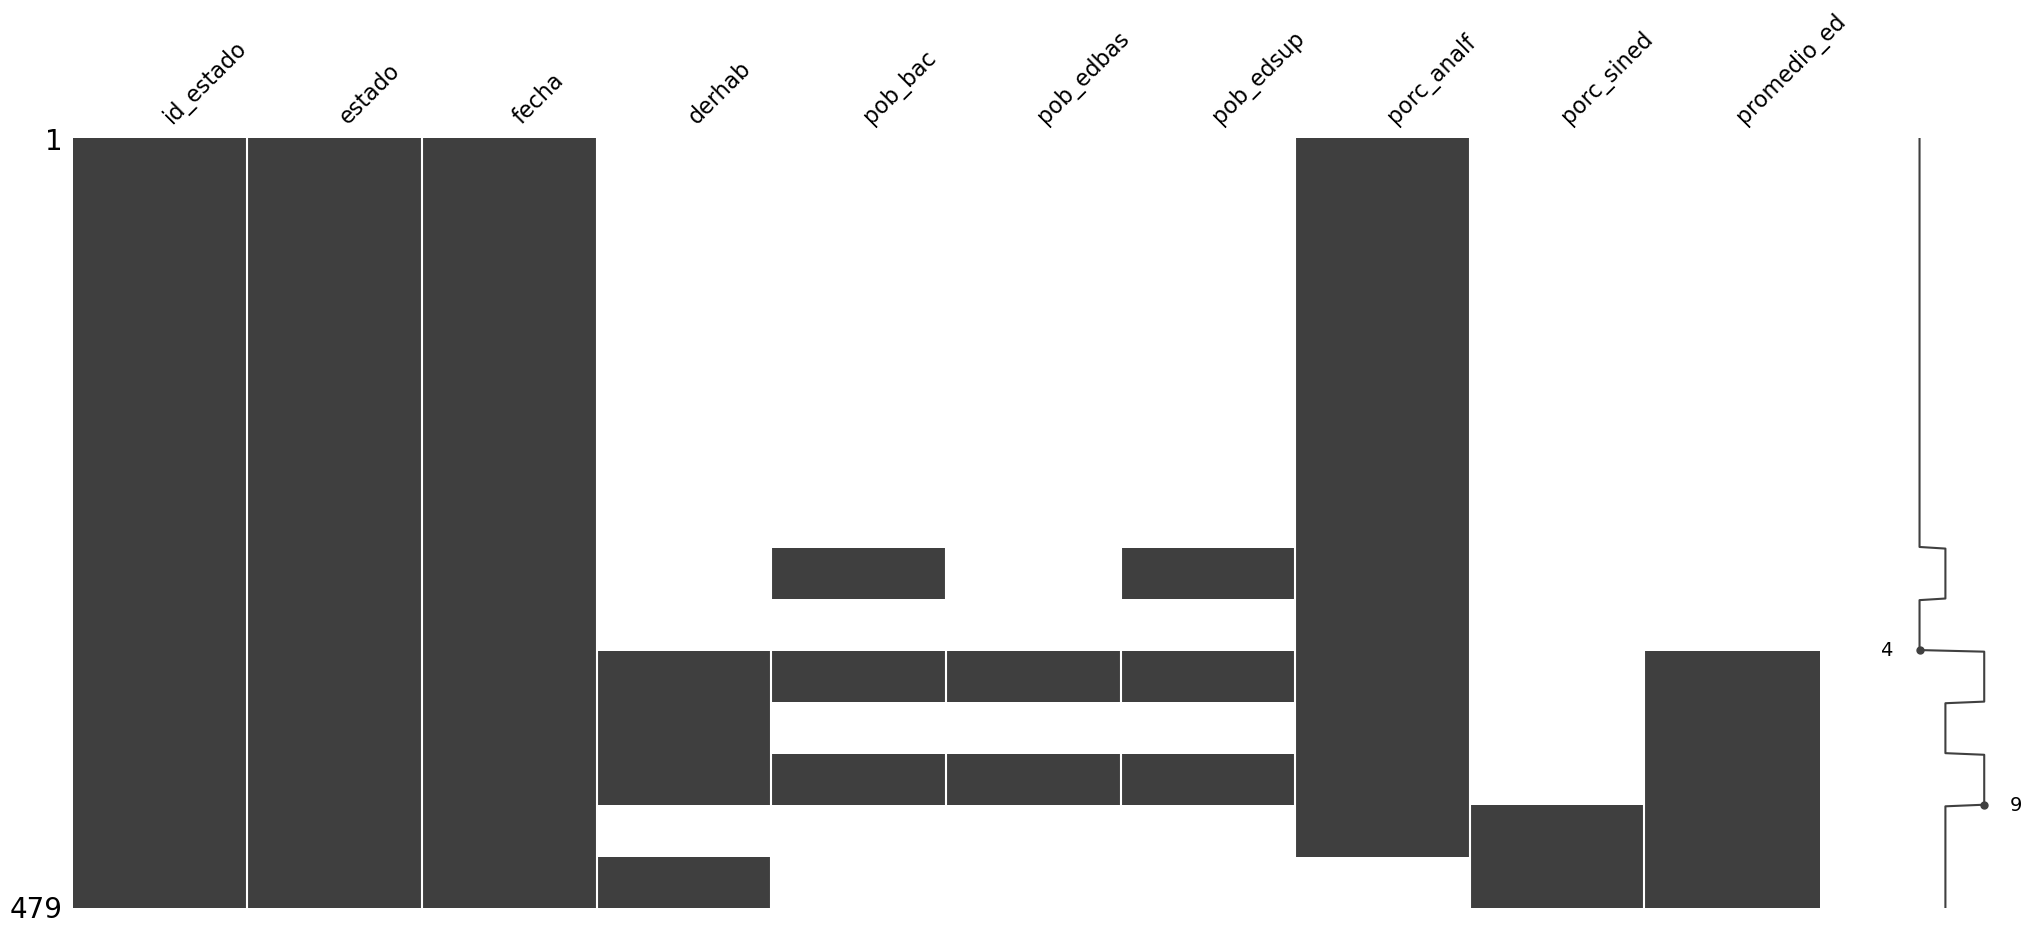

In [39]:
#%pip install missingno
import missingno as msno

#Limpieza de valores nulos
msno.matrix(df_edu_wide.sort_values('fecha'))

In [105]:
df_edu_wide[(df_edu_wide['derhab'].notnull())].sort_values('fecha').tail(50)

,id_estado,estado,fecha,derhab,pob_bac,pob_edbas,pob_edsup,porc_analf,porc_sined,promedio_ed
431,29,Tlaxcala,2010,720545.0,102983.0,487736.0,94736.0,5.19,NaN,8.780000
161,11,Guanajuato,2010,3822471.0,388626.0,2372907.0,349057.0,8.18,NaN,7.730000
206,14,Jalisco,2010,4709272.0,635897.0,3009017.0,728641.0,4.36,NaN,8.780000
146,10,Durango,2010,1113493.0,644247.0,692776.0,127530.0,3.82,NaN,8.580000
221,15,México,2010,8811664.0,1565560.0,5971664.0,1404965.0,4.38,NaN,9.100000
131,09,Ciudad de México,2010,5644901.0,1143966.0,2937137.0,1628840.0,2.09,NaN,10.540000
236,16,Michoacán de Ocampo,2010,2359537.0,286267.0,1864274.0,282413.0,10.18,NaN,7.420000
476,32,Zacatecas,2010,1020487.0,89648.0,687233.0,98050.0,5.55,NaN,7.900000
71,05,Coahuila de Zaragoza,2010,2103178.0,219124.0,1089165.0,306864.0,2.63,NaN,9.470000
116,08,Chihuahua,2010,2489301.0,524060.0,1379377.0,292920.0,3.66,NaN,8.820000
